In [1]:
%matplotlib inline

In [2]:
from bentso.constants import ENTSO_COUNTRIES
from pathlib import Path
import bentso
import brightway2 as bw
import numpy as np
import os
import presamples
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
bw.projects.set_current("SETAC 2019")

# Compare ENTSO-E modified database to original ecoinvent

In [9]:
IPCC = ('IPCC 2013', 'climate change', 'GWP 100a')

In [6]:
markets = [x for x in bw.Database("ecoinvent 3.5 cutoff") 
           if x['location'] in ENTSO_COUNTRIES 
           and x['name'] == 'market for electricity, high voltage']

In [7]:
lca = bw.LCA({markets[0]: 1}, IPCC)
lca.lci()
lca.lcia()

In [8]:
results_original = {}

for ds in markets:
    lca.redo_lcia({ds: 1})
    results_original[ds['location']] = lca.score

In [9]:
markets = [x for x in bw.Database("ecoinvent 3.5 ENTSO-E") 
           if x['location'] in ENTSO_COUNTRIES 
           and x['name'] == 'market for electricity, high voltage']

In [10]:
results_modified = {}

In [11]:
lca = bw.LCA({markets[0]: 1}, IPCC)
lca.lci()
lca.lcia()

In [12]:
results_modified = {}

for ds in markets:
    lca.redo_lcia({ds: 1})
    results_modified[ds['location']] = lca.score

In [13]:
keys = sorted(ENTSO_COUNTRIES)

In [14]:
xs = [results_original[key] for key in keys]
ys = [results_modified[key] for key in keys]

(0, 1.2)

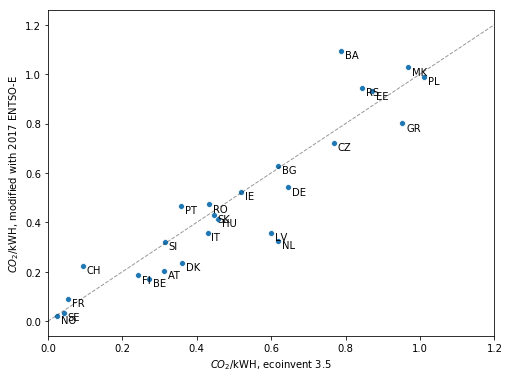

In [21]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1.2], [0, 1.2], 'k--', lw=1, alpha=0.4)
sb.scatterplot(xs, ys)

for x, y, z in zip(xs, ys, keys):
    plt.text(x + .01, y - .03, z)


plt.xlabel(r"$CO_{2}$/kWH, ecoinvent 3.5")
plt.ylabel(r"$CO_{2}$/kWH, modified with 2017 ENTSO-E")
plt.ylim(0, 1.2) 
plt.xlim(0, 1.2)

# Graph Monte Carlo results with and without presamples

In [22]:
bw.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.5 ENTSO-E
	ecoinvent 3.5 cutoff

In [15]:
func_unit = next(ds for ds in bw.Database("ecoinvent 3.5 ENTSO-E")
                 if ds['name'] == "market group for electricity, high voltage"
                 and ds['location'] == 'ENTSO-E')

In [16]:
mc = bw.MonteCarloLCA({func_unit: 1}, IPCC)
result = np.array([next(mc) for _ in range(500)])
np.average(result)

0.3113201311881226

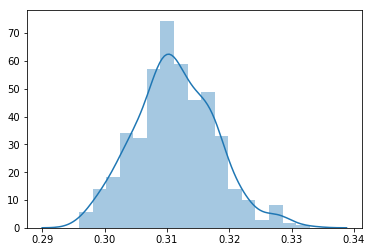

In [17]:
sb.distplot(result)

In [18]:
mc = bw.MonteCarloLCA({func_unit: 1}, IPCC, presamples=presamples.Campaign.get(name="ENTSO-E 2017"))
result = np.array([next(mc) for _ in range(500)])
np.average(result)

0.22824794601797693

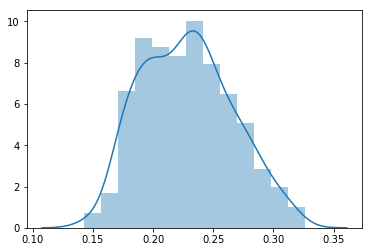

In [19]:
sb.distplot(result)

In [20]:
func_unit = next(ds for ds in bw.Database("ecoinvent 3.5 cutoff")
                 if ds['name'] == "market group for electricity, high voltage"
                 and ds['location'] == 'ENTSO-E')

In [21]:
mc = bw.MonteCarloLCA({func_unit: 1}, IPCC)
result = np.array([next(mc) for _ in range(500)])
np.average(result)

0.4297004738639761

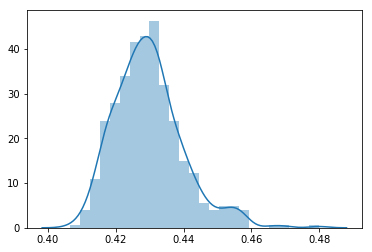

In [22]:
sb.distplot(result)

# Results for Finland

In [5]:
c = bentso.CachingDataClient(key="cache-only")

Using data directory /Users/cmutel/Library/Application Support/bentso


In [6]:
fi = c.get_generation("FI", 2017, clean=True, full_year=True)

In [7]:
fi.sum()

Biomass                            7.343433e+06
Fossil Gas                         4.220744e+06
Fossil Hard coal                   5.959023e+06
Fossil Oil                         1.769475e+04
Fossil Peat                        3.707953e+06
Hydro Run-of-river and poundage    1.423425e+07
Nuclear                            2.198310e+07
Waste                              2.156787e+05
Wind Onshore                       4.256954e+06
dtype: float64

(0, 3200)

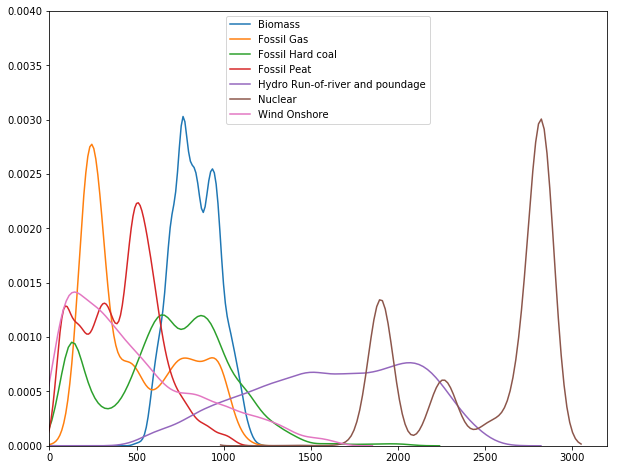

In [23]:
plt.figure(figsize=(10, 8))

for col in fi:
    if col in ('Waste', 'Fossil Oil'):
        continue
    sb.distplot(fi[col].values, label=col, hist=False)
    
plt.legend()
plt.ylim(0, 0.004)
plt.xlim(0, 3200)

In [64]:
np.average(fi.sum(axis=1))

7070.128085009142

In [65]:
65 * 1e6 / 8760

7420.091324200913

In [23]:
func_unit = next(ds for ds in bw.Database("ecoinvent 3.5 ENTSO-E")
                 if ds['name'] == "market for electricity, high voltage"
                 and ds['location'] == 'FI')

In [24]:
mc = bw.MonteCarloLCA({func_unit: 1}, IPCC)
result = np.array([next(mc) for _ in range(500)])
np.average(result)

0.19425333082029267

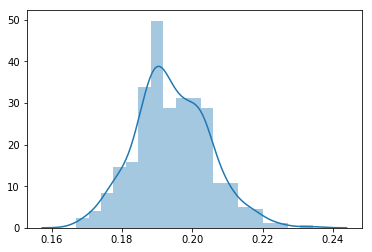

In [25]:
sb.distplot(result)

In [26]:
mc = bw.MonteCarloLCA({func_unit: 1}, IPCC, presamples=presamples.Campaign.get(name="ENTSO-E 2017"))
result = np.array([next(mc) for _ in range(500)])
np.average(result)

0.1902897496845834

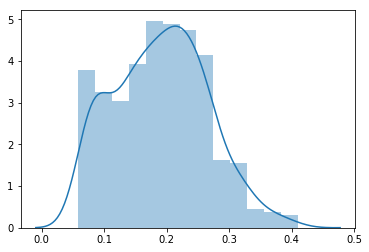

In [27]:
sb.distplot(result)